## Example of temporal delay and magnitude on regression in BOLD
[reference post](https://www.facebook.com/groups/mumfordbrainstats/permalink/1701000676662109/)

code was inspired from [chrisfilo RTmodelling](https://github.com/poldrack/fmri-analysis-vm/blob/master/analysis/RTmodeling/RTmodeling.ipynb)

This notebook will demonstrate the impact of increasing magnitude and delaying the hrf in an example "task".

In [10]:
%matplotlib inline
from nipy.modalities.fmri.hemodynamic_models import spm_hrf
import matplotlib.pyplot as plt
import numpy as np

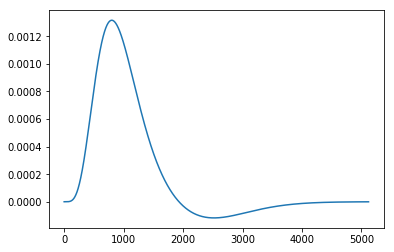

In [34]:
# Packages such as FSL often sample the HRF at a much higher resolution than we would typically use ...
# when collecting data (e.g. TR = 2 seconds)
design_resolution=0.1
# example hrf
plt.plot(spm_hrf(design_resolution))

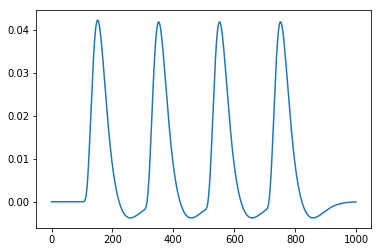

In [40]:
# the task is 1000 seconds long with 4 events that each last 2 seconds
stimulus_onsets = np.zeros(1000)
stimulus_onsets[100:102] = 1
stimulus_onsets[300:302] = 1
stimulus_onsets[500:502] = 1
stimulus_onsets[700:702] = 1

bold_design = np.convolve(stimulus_onsets,
                          spm_hrf(design_resolution, oversampling=1))[0:len(stimulus_onsets)]

plt.plot(bold_design)

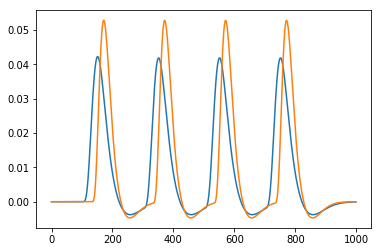

In [91]:
# the actual resolution of our scans
tr = 2
delayed_onsets = np.zeros(1000)

# the super large hrfs are delayed 30 seconds
delayed_onsets[130:132] = 1
delayed_onsets[330:332] = 1
delayed_onsets[530:532] = 1
delayed_onsets[730:732] = 1


delayed_bold = np.convolve(delayed_onsets,
                          spm_hrf(tr))[0:len(delayed_onsets)]


plt.plot(bold_design)
plt.plot(delayed_bold)

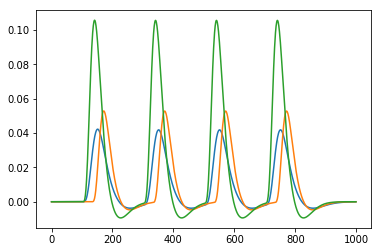

In [92]:
# same as design_bold, but twice as large and sampled at 2 seconds
increased_magnitude_bold = np.convolve(stimulus_onsets,
                                       spm_hrf(tr)*2)[0:len(stimulus_onsets)]

plt.plot(bold_design)
plt.plot(delayed_bold)
plt.plot(increased_magnitude_bold)

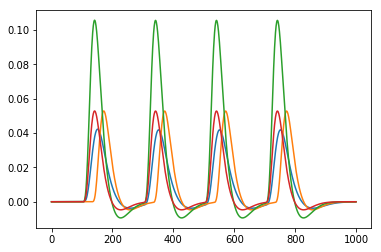

In [93]:
# same as design_bold sampled at 2 seconds
perfect_bold = np.convolve(stimulus_onsets,
                           spm_hrf(tr))[0:len(stimulus_onsets)]



plt.plot(bold_design)
plt.plot(delayed_bold)
plt.plot(increased_magnitude_bold)
plt.plot(perfect_bold)

In [95]:
# typical design matrices have a column of ones as b0, and subsequent regressors as b1, b2, etc.
# in this case all we have is b0 and b1
intercept = np.ones(1000)
design_matrix = np.vstack([intercept, bold_design]).T

In [96]:
# short review of matrix regression: https://onlinecourses.science.psu.edu/stat501/node/382/
# (X'X)^-1
psuedo_inverse = np.linalg.pinv(np.dot(design_matrix.T, design_matrix))

# (X'X)^-1X'
x_var = np.dot(psuedo_inverse, design_matrix.T)

# (X'X)^-1X'Y
perfect_bold_betas = np.dot(x_var, perfect_bold)
delayed_bold_betas = np.dot(x_var, delayed_bold)
increased_magnitude_bold_betas = np.dot(x_var, increased_magnitude_bold)

print('perfect bold betas: {}'.format(perfect_bold_betas))
print('delayed bold betas: {}'.format(delayed_bold_betas))
print('increased magnitude bold betas: {}'.format(increased_magnitude_bold_betas))

perfect bold betas: [ -3.64213252e-04   1.04545428e+00]
delayed bold betas: [ 0.00161127  0.79853537]
increased magnitude bold betas: [ -7.28426505e-04   2.09090855e+00]


## Notes
In each case $b_0$ was close to zero, which makes sense because I didn't change the baseline of each of the bold signals.

**perfect bold**: $b_1$ is close to 1 (as expected) since the bold signal was essentially the bold design except sampled at a lower frequency resulting in some error (and I'm not quite sure of the impact of oversampling)

**delayed bold**: $b_1$ is less than 1 suggesting either the magnitude is lower or there is temporal mismatch. As we know (since we made the signal) the magnitude is the same as the perfect bold, suggesting we didn't appropriately model the temporal mismatch (we didn't).

**increased magnitude bold**: $b_1$ is close to 2 which makes sense because this bold signal is the same as perfect bold except multiplied by a constant making it larger.

In [104]:
# correlating bold_design with the respective signals

perfect_bold_r = np.corrcoef(bold_design, perfect_bold)

delayed_bold_r = np.corrcoef(bold_design, delayed_bold)

increased_magnitude_bold_r = np.corrcoef(bold_design, increased_magnitude_bold)

print('perfect bold pearson\'s r: \n{}\n'.format(perfect_bold_r))
print('delayed bold pearson\'s r: \n{}\n'.format(delayed_bold_r))
print('increased magnitude bold pearson\'s r: \n{}\n'.format(increased_magnitude_bold_r))

perfect bold pearson's r: 
[[ 1.          0.89874635]
 [ 0.89874635  1.        ]]

delayed bold pearson's r: 
[[ 1.          0.68647741]
 [ 0.68647741  1.        ]]

increased magnitude bold pearson's r: 
[[ 1.          0.89874635]
 [ 0.89874635  1.        ]]



## Notes

the perfect bold and increased magnitude bold have the same pearson's correlation coefficient since they are essentially the same data, one is just multiplied by a factor. Looking at the [pearson's correlation coefficient equation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), try to convince yourself that if we increase the variance in $Y$ by multiplying it by a constant, the effect on the result is null because $Y$'s variance is included in both the numerator and the demonenator.

The delayed bold signal has a smaller correlation.

## General Conclusions

I could tell the difference between a low magnitude bold response and a temporally delayed bold response by looking at the betas and correlation coefficient since the former would still have a high correlation coefficient, but the later would not, even if they had the same beta values.

This also hits home the point that residuals are important and always check your modelling assumptions